# Setup

In [2]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [3]:
import pandas as pd
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
import torch
import sys
sys.path.append(os.path.expanduser("~")+'/gan-control/notebooks/')
sys.path.append(os.path.expanduser("~")+'/gan-control/src/')
from add_lowlevel import DIMENSION, LENGTH_CURVE, LENGTH_SEGMENT, SIDELENGTH_LATTICE, IDX_MAX_LATTICE, IDX_MIN_LATTICE, LENGTH_SEGMENT_LOW_LEVEL, L_DIM_LOWLEVEL

In [4]:
l_dim = list(str(x) for x in range(DIMENSION)) + L_DIM_LOWLEVEL
idx_max_lattice = SIDELENGTH_LATTICE+(LENGTH_CURVE-1)//2
idx_min_lattice = (LENGTH_CURVE-1)//2
print(l_dim, idx_max_lattice, idx_min_lattice)

['0', '1', '2', '3', '4', 'brightness', 'contrast', 'hue'] 6 1


In [6]:
# generated

model_name = "arcface"
d_metric = {"facenet":"euclidean", "arcface":"cosine"}
d_scale = {"facenet":0.9, "arcface":0.7}
a_embeddings = np.load(os.path.expanduser("~") + f"/tda-face-recognition/data/generated_synthetic/gan_control/embeddings/vanilla/arcface/r18/20241019_1747_0.npy")
df_points = pd.read_csv(os.path.expanduser("~") + "/tda-face-recognition/data/generated_synthetic/gan_control/images_112/df_points.csv")
df_points.shape, a_embeddings.shape

((121875, 10), (121875, 512))

In [7]:
for i in range(len(l_dim)):
    df_points[f"group_{l_dim[i]}"] = df_points.groupby(l_dim[:i]+l_dim[i+1:]).grouper.group_info[0]
n_groups = df_points["group_0"].max()+1
n_groups

21125

0
1
2
3
4


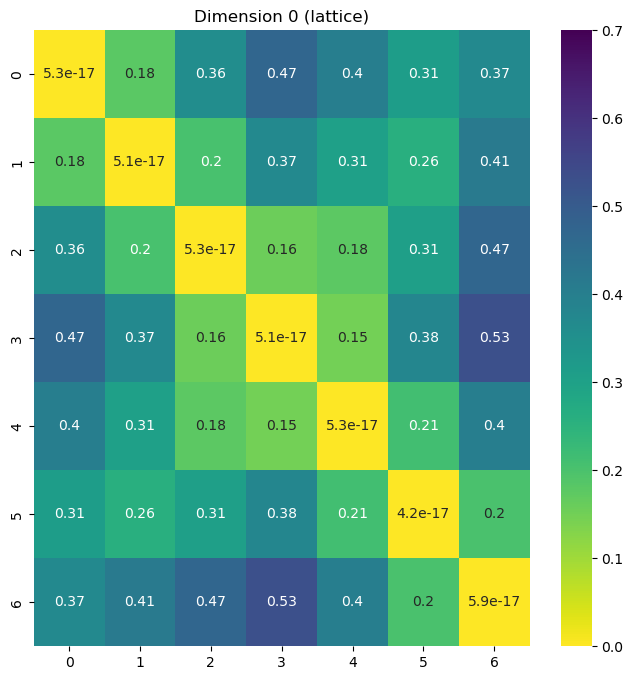

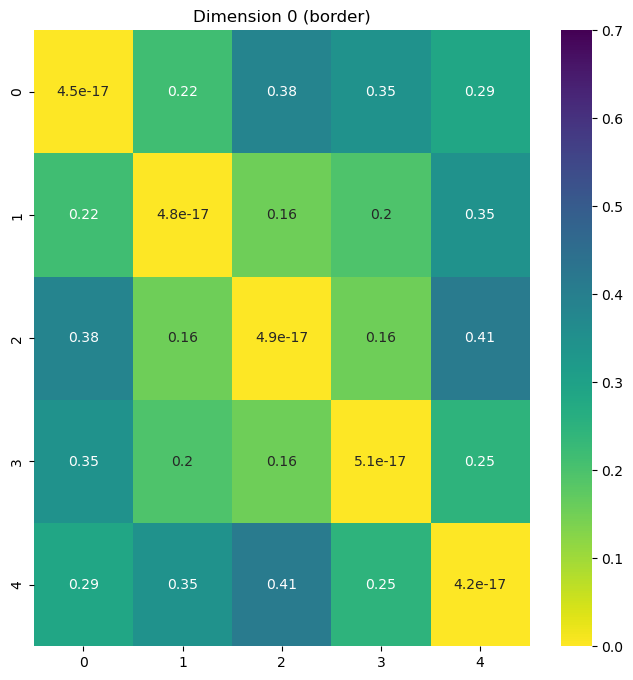

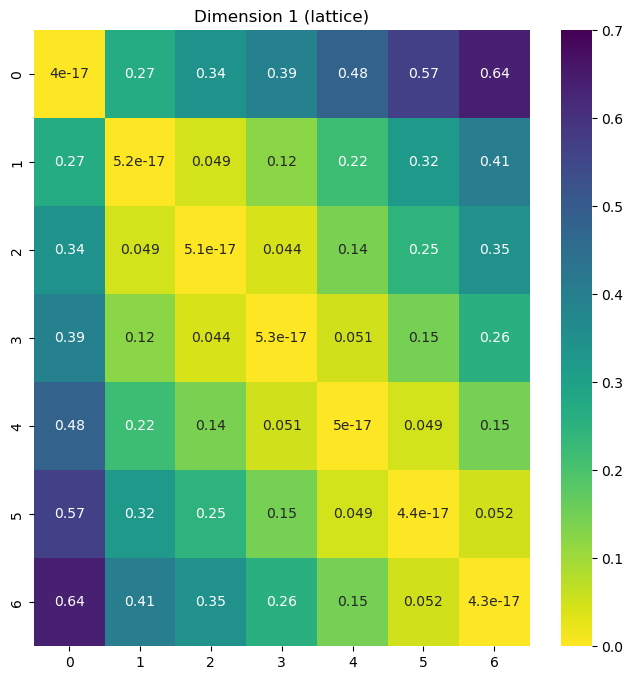

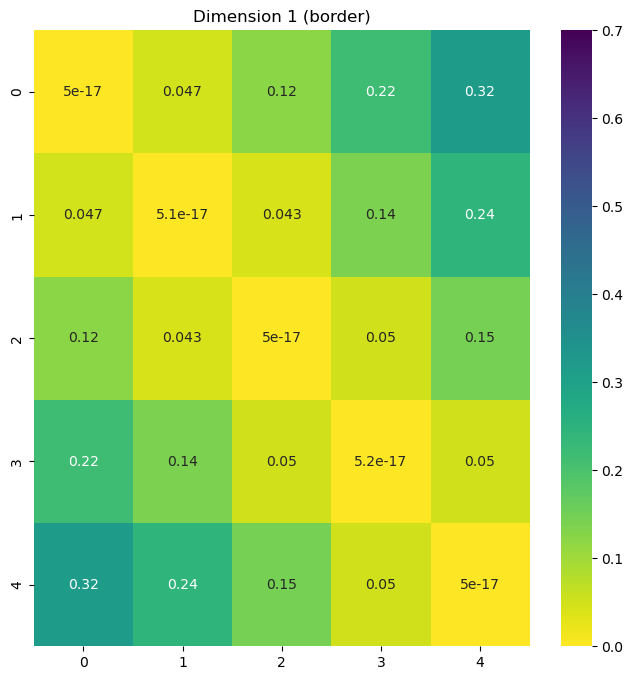

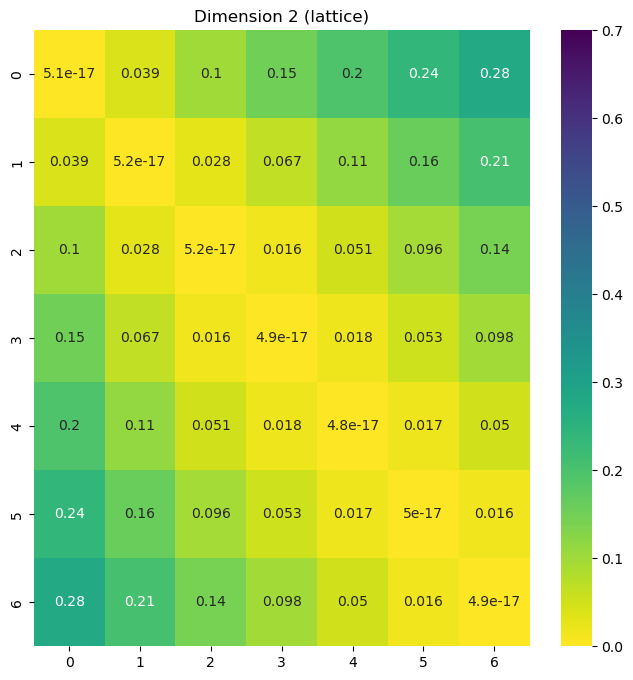

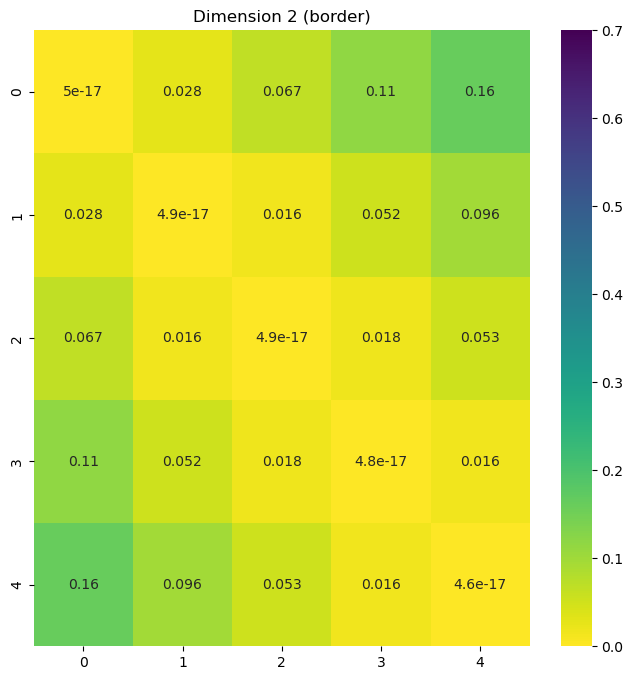

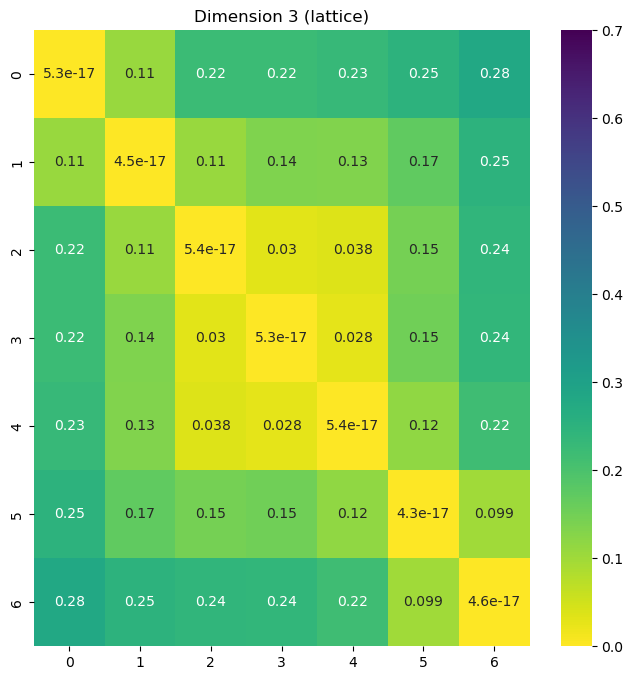

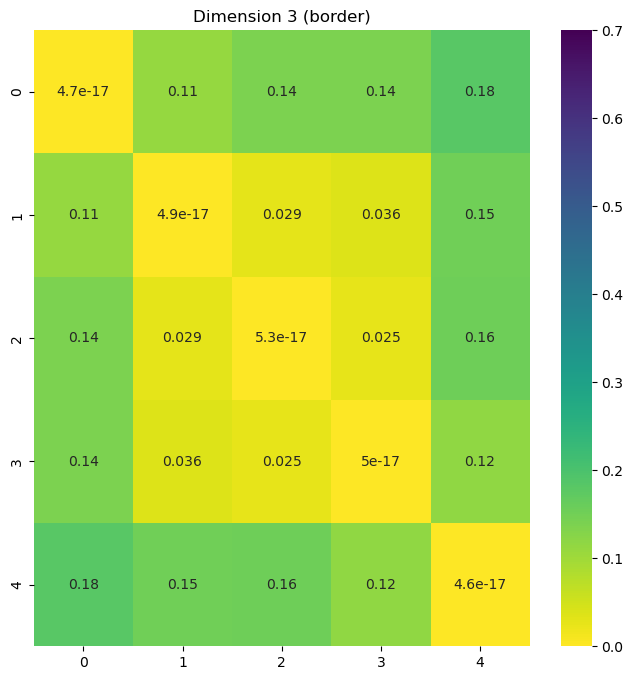

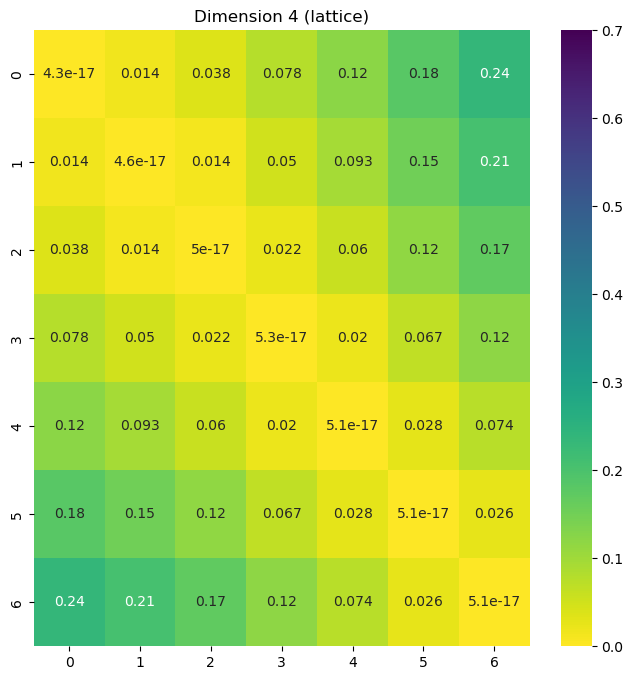

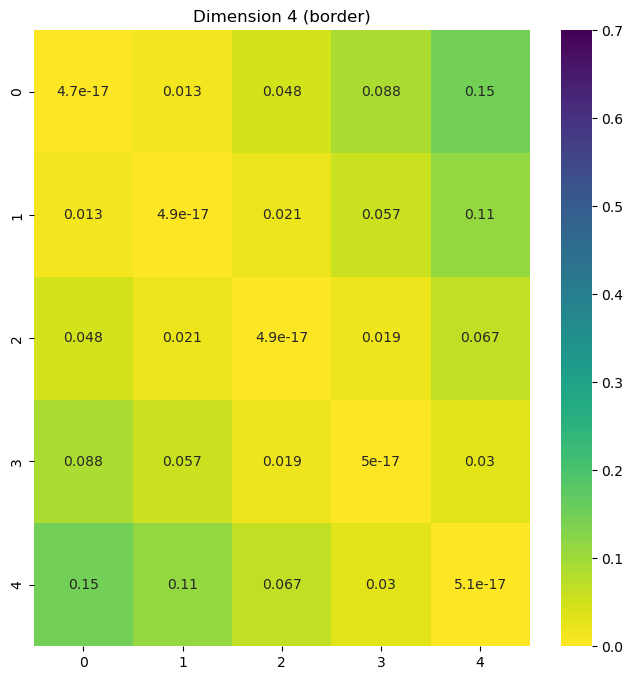

In [8]:
# evaluation of high level attributes
for dimension in l_dim[:DIMENSION]:
    print(dimension)
    edm_border = np.zeros((SIDELENGTH_LATTICE, SIDELENGTH_LATTICE))  # when the fixed part is in the border, the varying only varies in the lattice
    edm_lattice = np.zeros((LENGTH_SEGMENT, LENGTH_SEGMENT))  # when the fixed part is in the lattice, the varying part varies along the whole segment
    n_border, n_lattice = 0, 0
    for g in range(n_groups):
        a = df_points[df_points[f"group_{dimension}"]==g].sort_values(by=dimension).index
        if len(a)==SIDELENGTH_LATTICE:
            edm_border += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
            n_border += 1
        elif len(a)==LENGTH_SEGMENT:
            edm_lattice += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
            n_lattice += 1
    edm_border = edm_border/n_border
    edm_lattice = edm_lattice/n_lattice

    fig, ax = plt.subplots(figsize=(8,8))    
    sns.heatmap(edm_lattice, annot=True, fmt=".2g", cmap='viridis_r'
                , vmin=0., vmax=d_scale[model_name]
               )
    ax.set_title(f"Dimension {dimension} (lattice)")

    fig, ax = plt.subplots(figsize=(8,8))    
    sns.heatmap(edm_border, annot=True, fmt=".2g", cmap='viridis_r'
                , vmin=0., vmax=d_scale[model_name]
               )
    ax.set_title(f"Dimension {dimension} (border)")

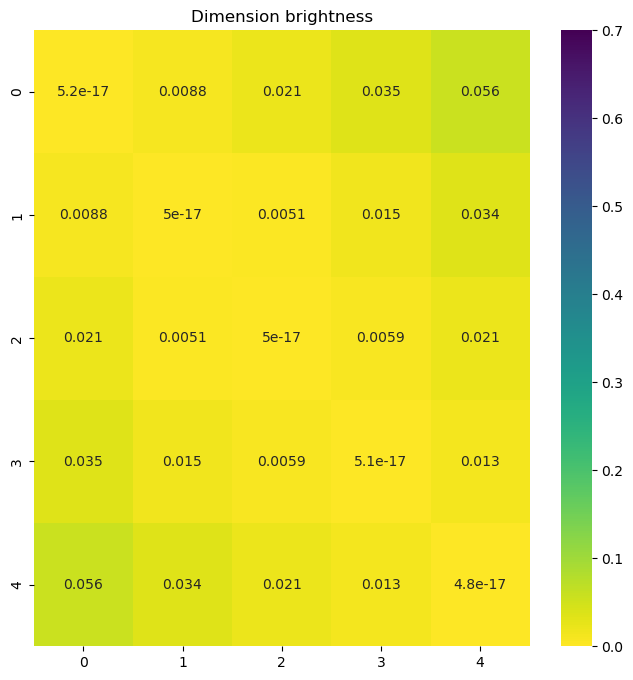

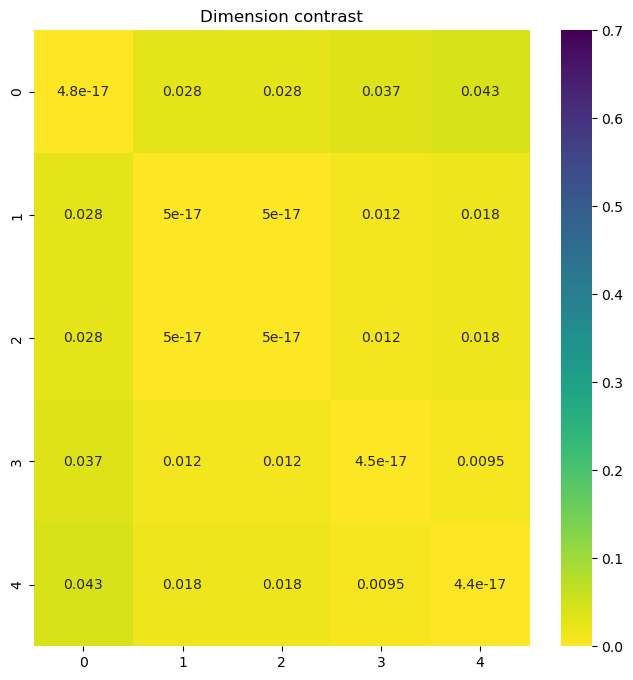

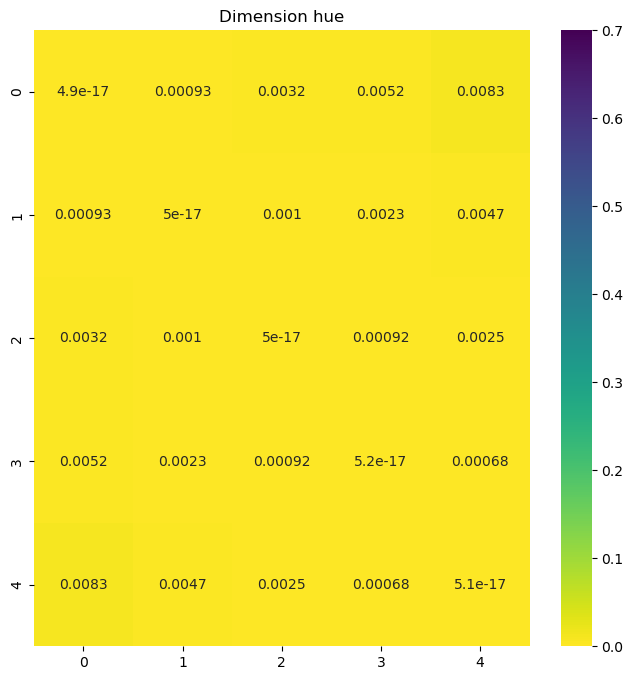

In [9]:
for i, dim in enumerate(L_DIM_LOWLEVEL):
    df = df_points.loc[((df_points[L_DIM_LOWLEVEL[:i]+L_DIM_LOWLEVEL[i+1:]] == (LENGTH_SEGMENT_LOW_LEVEL-1)//2).all(axis=1))]
    edm = np.zeros((LENGTH_SEGMENT_LOW_LEVEL, LENGTH_SEGMENT_LOW_LEVEL))
    l_groups = df[f"group_{dim}"].unique()
    for group in l_groups:
        a = df_points[df_points[f"group_{dim}"]==group].sort_values(by=dim).index
        edm += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
    edm /= len(l_groups)
    fig, ax = plt.subplots(figsize=(8,8))    
    sns.heatmap(edm, annot=True, fmt=".2g", cmap='viridis_r'
                , vmin=0., vmax=d_scale[model_name]
               )
    ax.set_title(f"Dimension {dim}")

# Staged

## Plots for the paper

In [ ]:
# evaluation of high level attributes
for dimension in l_dim[:DIMENSION]:
    print(dimension)
    edm_border = np.zeros((SIDELENGTH_LATTICE, SIDELENGTH_LATTICE))  # when the fixed part is in the border, the varying only varies in the lattice
    edm_lattice = np.zeros((LENGTH_SEGMENT, LENGTH_SEGMENT))  # when the fixed part is in the lattice, the varying part varies along the whole segment
    n_border, n_lattice = 0, 0
    for g in range(n_groups):
        a = df_points[df_points[f"group_{dimension}"]==g].sort_values(by=dimension).index
        if len(a)==SIDELENGTH_LATTICE:
            edm_border += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
            n_border += 1
        elif len(a)==LENGTH_SEGMENT:
            edm_lattice += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
            n_lattice += 1
    edm_border = edm_border/n_border
    edm_lattice = edm_lattice/n_lattice

    fig, ax = plt.subplots(figsize=(8,8))    
    sns.heatmap(edm_lattice, annot=True, fmt=".2g", cmap='viridis_r'
                , vmin=0., vmax=d_scale[model_name]
               )
    ax.set_title(f"Dimension {dimension} (lattice)")

    fig, ax = plt.subplots(figsize=(8,8))    
    sns.heatmap(edm_border, annot=True, fmt=".2g", cmap='viridis_r'
                , vmin=0., vmax=d_scale[model_name]
               )
    ax.set_title(f"Dimension {dimension} (border)")

Text(0.5, 1.0, 'Dimension 0 (border)')

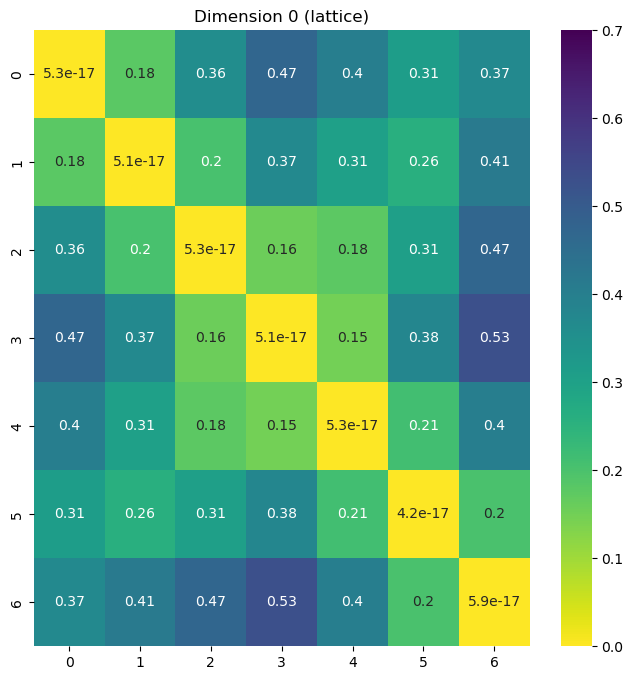

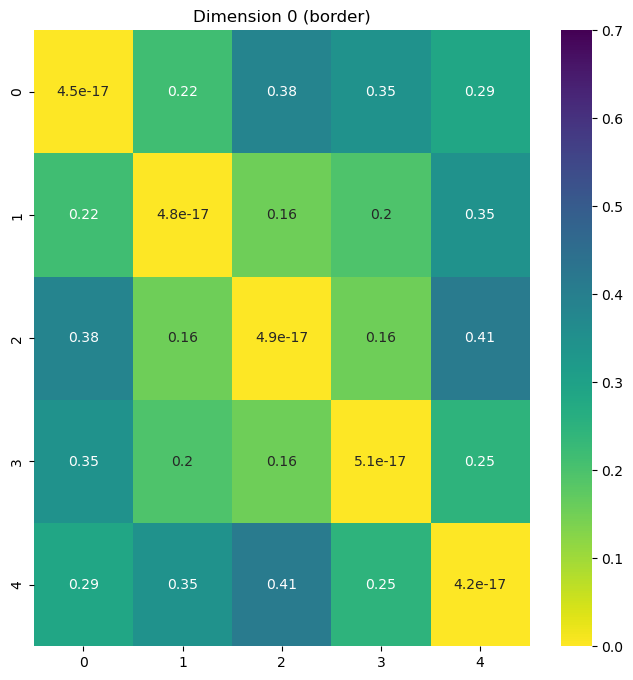

In [13]:
dimension = '0'

edm_border = np.zeros((SIDELENGTH_LATTICE, SIDELENGTH_LATTICE))  # when the fixed part is in the border, the varying only varies in the lattice
edm_lattice = np.zeros((LENGTH_SEGMENT, LENGTH_SEGMENT))  # when the fixed part is in the lattice, the varying part varies along the whole segment
n_border, n_lattice = 0, 0
for g in range(n_groups):
    a = df_points[df_points[f"group_{dimension}"]==g].sort_values(by=dimension).index
    if len(a)==SIDELENGTH_LATTICE:
        edm_border += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
        n_border += 1
    elif len(a)==LENGTH_SEGMENT:
        edm_lattice += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
        n_lattice += 1
edm_border = edm_border/n_border
edm_lattice = edm_lattice/n_lattice

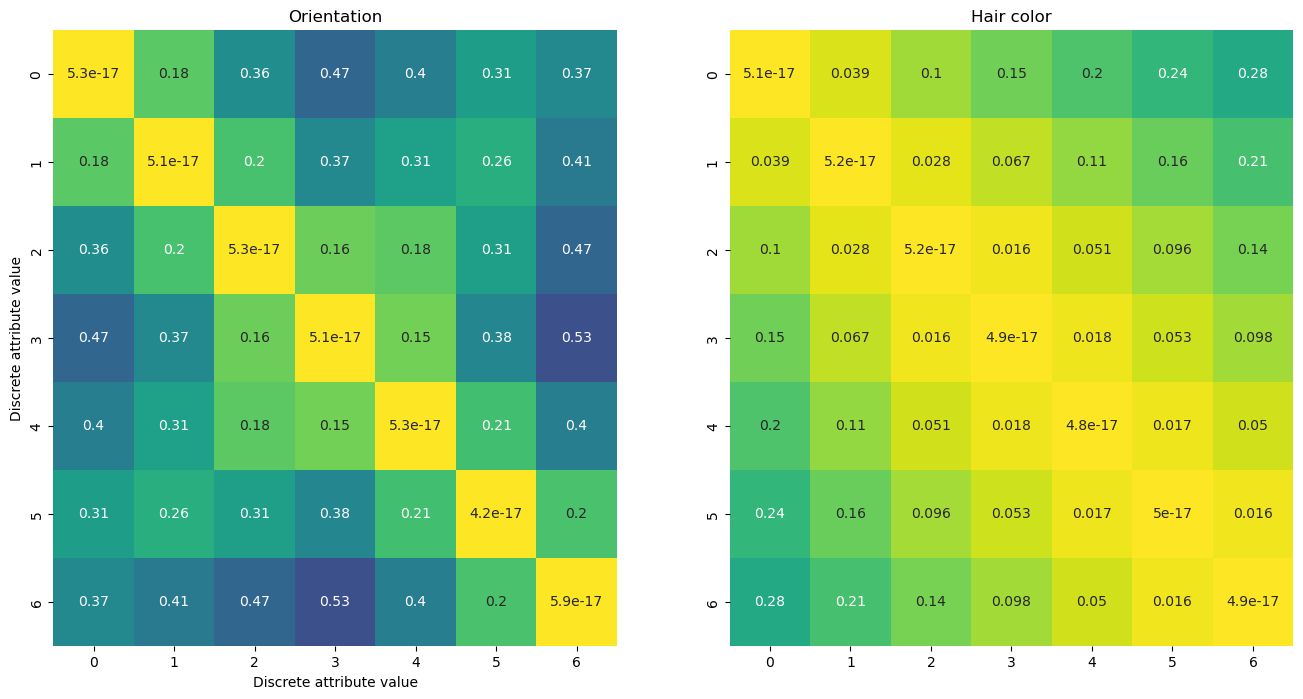

In [22]:
dimension = '0'

edm_border = np.zeros((SIDELENGTH_LATTICE, SIDELENGTH_LATTICE))  # when the fixed part is in the border, the varying only varies in the lattice
edm_lattice = np.zeros((LENGTH_SEGMENT, LENGTH_SEGMENT))  # when the fixed part is in the lattice, the varying part varies along the whole segment
n_border, n_lattice = 0, 0
for g in range(n_groups):
    a = df_points[df_points[f"group_{dimension}"]==g].sort_values(by=dimension).index
    if len(a)==SIDELENGTH_LATTICE:
        edm_border += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
        n_border += 1
    elif len(a)==LENGTH_SEGMENT:
        edm_lattice += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
        n_lattice += 1
edm_border = edm_border/n_border
edm_lattice = edm_lattice/n_lattice

fig, axes = plt.subplots(1, 2, figsize=(16,8))    
s = sns.heatmap(edm_lattice, annot=True, fmt=".2g", cmap='viridis_r'
            , vmin=0., vmax=d_scale[model_name], ax=axes[0], cbar=False)
axes[0].set_title(f"Orientation")
s.set(xlabel='Discrete attribute value', ylabel='Discrete attribute value')

dimension = '2'

edm_border = np.zeros((SIDELENGTH_LATTICE, SIDELENGTH_LATTICE))  # when the fixed part is in the border, the varying only varies in the lattice
edm_lattice = np.zeros((LENGTH_SEGMENT, LENGTH_SEGMENT))  # when the fixed part is in the lattice, the varying part varies along the whole segment
n_border, n_lattice = 0, 0
for g in range(n_groups):
    a = df_points[df_points[f"group_{dimension}"]==g].sort_values(by=dimension).index
    if len(a)==SIDELENGTH_LATTICE:
        edm_border += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
        n_border += 1
    elif len(a)==LENGTH_SEGMENT:
        edm_lattice += scipy.spatial.distance.cdist(a_embeddings[a], a_embeddings[a], metric=d_metric[model_name])
        n_lattice += 1
edm_border = edm_border/n_border
edm_lattice = edm_lattice/n_lattice


sns.heatmap(edm_lattice, annot=True, fmt=".2g", cmap='viridis_r'
            , vmin=0., vmax=d_scale[model_name], ax=axes[1], cbar=False)
axes[1].set_title(f"Hair color")
s.set(xlabel='Discrete attribute value')

plt.savefig("saved_plots/gancontrol_distances_id_retention.pdf",format="pdf", bbox_inches="tight")

# <>